# Bulldozer Price Prediction

In this notebook we use machine learning to predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

## Problem

> How well can we predict the future auction sale price of a bulldozer, using given characteristics and past examples of sale prices?

## Data

The data is from the Kaggle Bulldozers competition: https://www.kaggle.com/competitions/bluebook-for-bulldozers
There are three main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## Evaluation

RMSLE (root mean squared log error) between the actual and predicted auction prices

## Features

Data Dictionary - https://docs.google.com/spreadsheets/d/1n_fjuBkScmW8uWTuiVOo9zb7C8yodGf_R4t5SyFn410/edit?usp=sharing

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-dark")

from sklearn.ensemble import RandomForestRegressor

## Exploring Data

In [103]:
# importing training a validation set
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [105]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

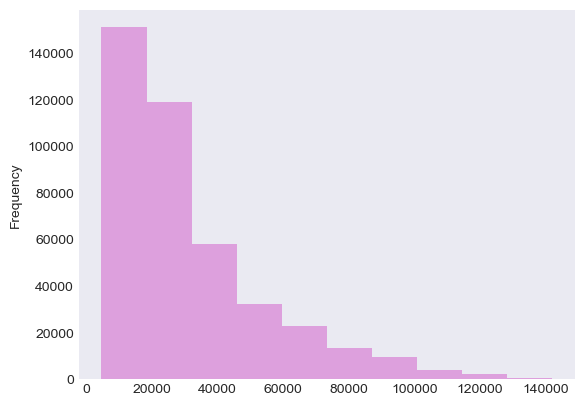

In [106]:
df.SalePrice.plot.hist(color="plum");

In [107]:
# parsing dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [108]:
df.saledate.dtype

dtype('<M8[ns]')

In [109]:
df.saledate[:5]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]

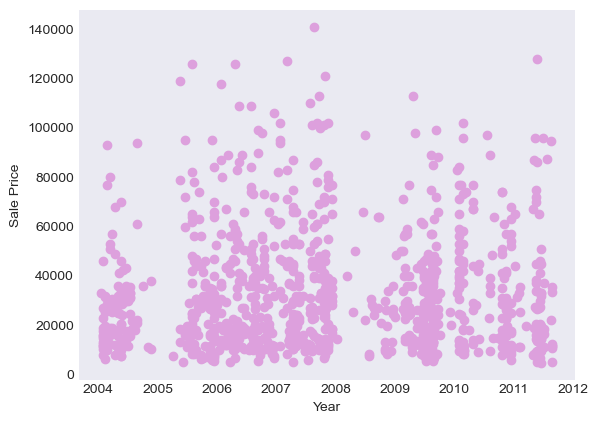

In [110]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000], color="plum")
plt.xlabel("Year")
plt.ylabel("Sale Price");

In [111]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate[:5]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [113]:
df_copy = df.copy()
df_copy.saledate[:5]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Feature Engineering

In [114]:
df["saleYear"] = df.saledate.dt.year
df.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int64

In [115]:
df["saleMonth"] = df.saledate.dt.month
df["saleDay"] = df.saledate.dt.day
df["saleDayOfWeek"] = df.saledate.dt.dayofweek
df["saleDayOfYear"] = df.saledate.dt.dayofyear
df["saleQuarter"] = df.saledate.dt.quarter

In [116]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,saleQuarter
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17,1
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,1
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31,1
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,1
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,PAT,Lever,NaN,NaN,1989,1,31,1,31,1


## Data Cleaning

In [117]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [118]:
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        df[label] = content.astype("category").cat.as_ordered()

In [119]:
df.state.cat.codes[:10]

205615    43
274835     8
141296     8
212552     8
62755      8
54653      8
81383      8
204924     8
135376     8
113390     8
dtype: int8

In [120]:
df.state[:8]

205615      Texas
274835    Florida
141296    Florida
212552    Florida
62755     Florida
54653     Florida
81383     Florida
204924    Florida
Name: state, dtype: category
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

In [121]:
df.dtypes

SalesID                              int64
SalePrice                          float64
MachineID                            int64
ModelID                              int64
datasource                           int64
auctioneerID                       float64
YearMade                             int64
MachineHoursCurrentMeter           float64
UsageBand                         category
saledate                    datetime64[ns]
fiModelDesc                       category
fiBaseModel                       category
fiSecondaryDesc                   category
fiModelSeries                     category
fiModelDescriptor                 category
ProductSize                       category
fiProductClassDesc                category
state                             category
ProductGroup                      category
ProductGroupDesc                  category
Drive_System                      category
Enclosure                         category
Forks                             category
Pad_Type   

In [122]:
df.isna().sum()/len(df)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
saledate                     0.000000
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission

In [123]:
df.to_csv("data/train_tmp.csv", index=False)

In [124]:
df = pd.read_csv("data/train_tmp.csv", low_memory=False)

In [125]:
df.drop("saledate", axis=1, inplace=True)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,saleQuarter
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17,1
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,1
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31,1
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,Standard,Conventional,1989,1,31,1,31,1
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,PAT,Lever,NaN,NaN,1989,1,31,1,31,1


In [126]:
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [127]:
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            df[label+"_is_missing"] = pd.isna(content)
            df[label] = content.fillna(content.median())

In [128]:
for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            print(label)

In [129]:
df.isna().sum()/len(df)*100

SalesID                                 0.000000
SalePrice                               0.000000
MachineID                               0.000000
ModelID                                 0.000000
datasource                              0.000000
auctioneerID                            0.000000
YearMade                                0.000000
MachineHoursCurrentMeter                0.000000
UsageBand                              82.149174
fiModelDesc                             0.000000
fiBaseModel                             0.000000
fiSecondaryDesc                        34.099269
fiModelSeries                          85.784520
fiModelDescriptor                      81.871490
ProductSize                            52.485110
fiProductClassDesc                      0.000000
state                                   0.000000
ProductGroup                            0.000000
ProductGroupDesc                        0.000000
Drive_System                           74.051970
Enclosure           

In [130]:
df.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [131]:
df.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [132]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [133]:
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            df[label+"_is_missing"] = pd.isna(content)
            df[label] = pd.Categorical(content).codes + 1 # we add 1 because the code for missing categorical value is -1
        else:
            df[label] = pd.Categorical(content).codes

In [134]:
df.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 98, dtype: int64

## Modelling

In [135]:
%%time
model = RandomForestRegressor(n_jobs=-1, random_state=8)

model.fit(df.drop("SalePrice", axis=1), df["SalePrice"])

CPU times: user 8min 53s, sys: 3.94 s, total: 8min 57s
Wall time: 1min 1s


RandomForestRegressor(n_jobs=-1, random_state=8)